# Rodriguez CD34+
## Xiaonan Wang
## 17Jan2023

In [2]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [15]:
adata = sc.read('./raw_afterQC_all_lognorm.h5ad')

In [16]:
adata.obs['CD34'] = adata[:,'CD34'].X.flatten()

In [17]:
adata.obs['CD34'] 

AAAGCAATCTTGCAAG-Patient_3    0.475990
AAAGTAGAGGAGCGAG-Patient_3    0.000000
AAAGTAGAGTCATCCA-Patient_3    0.000000
AAAGTAGCACAACGTT-Patient_3    0.324985
AACCATGCAATCGGTT-Patient_3    0.000000
                                ...   
TTTGCGCTCACCCTCA-Patient_7    0.000000
TTTGGTTAGCAATCTC-Patient_7    0.237070
TTTGGTTCATTGGGCC-Patient_7    0.000000
TTTGGTTTCAAACGGG-Patient_7    0.000000
TTTGTCACAGTATGCT-Patient_7    0.271696
Name: CD34, Length: 8275, dtype: float32

In [7]:
adata.shape

(8275, 49453)

<AxesSubplot:xlabel='CD34', ylabel='Density'>

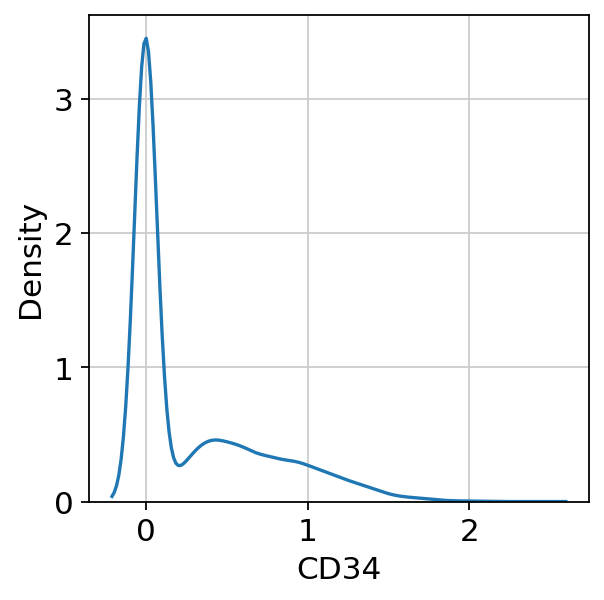

In [18]:
import seaborn as sns
sns.kdeplot(adata.obs['CD34'])

In [19]:
sum(adata.obs['CD34'] > 0.125)

3312

In [20]:
adata = adata[adata.obs['CD34'] > 0.125, :].copy()

In [21]:
adata.shape

(3312, 49453)

In [22]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.5, batch_key='plate', inplace=True)

extracting highly variable genes
    finished (0:00:10)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


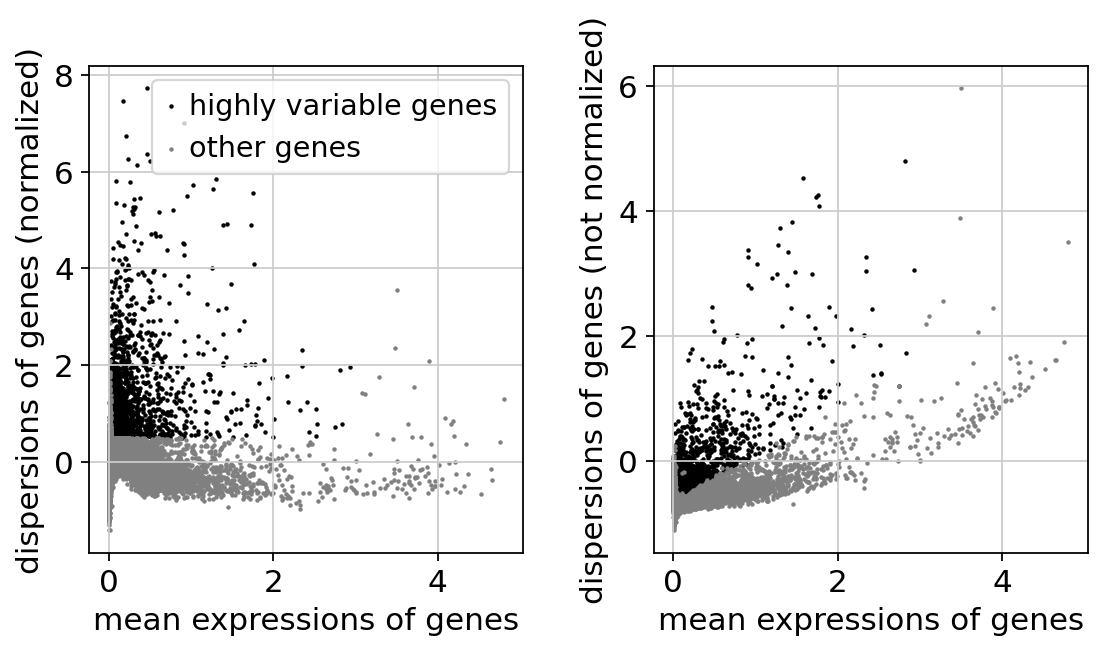

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
print(np.sum(adata.var.highly_variable))

2243


In [25]:
adata = adata[:, adata.var.highly_variable].copy()

In [26]:
adata.write('./CD34_raw_afterQC_all_lognorm_hvg.h5ad')

In [27]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


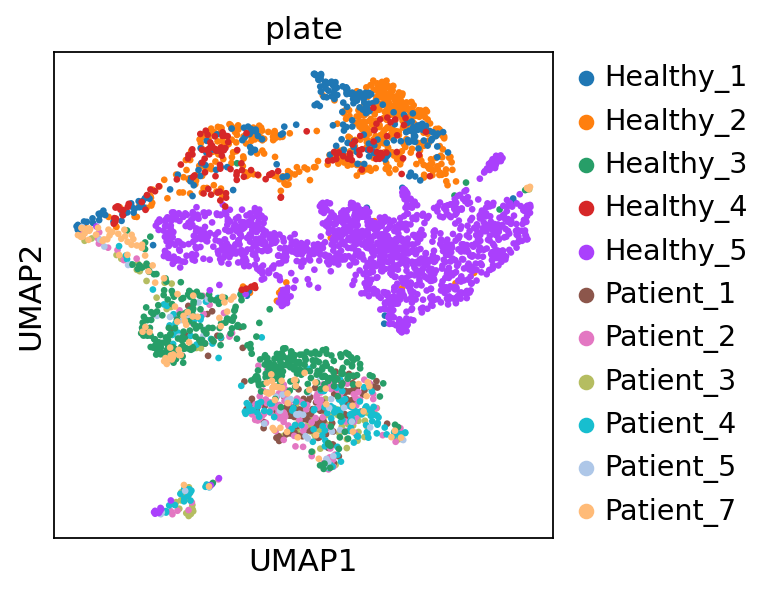

In [28]:
sc.pl.umap(adata, color=['plate'])

In [29]:
adata.write('./CD34_raw_afterQC_all_lognorm_hvg_processed.h5ad')

In [30]:
sc.external.pp.harmony_integrate(adata, key='plate')

2023-01-16 17:25:17,728 - harmonypy - INFO - Iteration 1 of 10
2023-01-16 17:25:18,206 - harmonypy - INFO - Iteration 2 of 10
2023-01-16 17:25:18,681 - harmonypy - INFO - Iteration 3 of 10
2023-01-16 17:25:19,157 - harmonypy - INFO - Iteration 4 of 10
2023-01-16 17:25:19,491 - harmonypy - INFO - Iteration 5 of 10
2023-01-16 17:25:19,887 - harmonypy - INFO - Iteration 6 of 10
2023-01-16 17:25:20,322 - harmonypy - INFO - Iteration 7 of 10
2023-01-16 17:25:20,678 - harmonypy - INFO - Iteration 8 of 10
2023-01-16 17:25:20,910 - harmonypy - INFO - Iteration 9 of 10
2023-01-16 17:25:21,205 - harmonypy - INFO - Iteration 10 of 10
2023-01-16 17:25:21,418 - harmonypy - INFO - Stopped before convergence


In [31]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


In [32]:
adata.obs['Condition'] = [x.split('_')[0] for x in adata.obs['plate']]

/home/xw251/miniconda3/envs/scanpy182/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Condition' as categorical


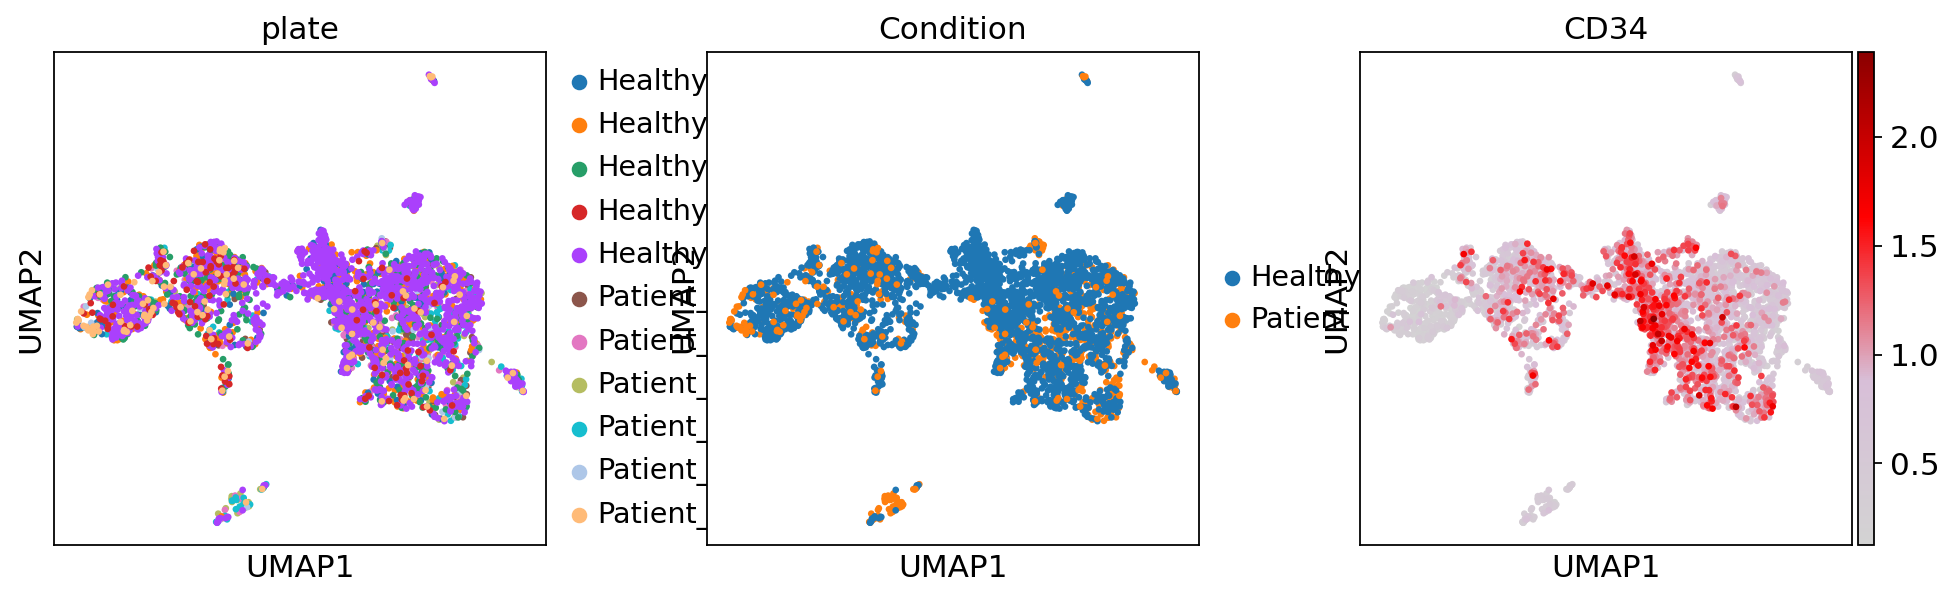

In [33]:
sc.pl.umap(adata, color=['plate', 'Condition', 'CD34'], color_map=cmap)

In [61]:
sc.tl.leiden(adata, resolution=1, key_added='Leiden_v1')

running Leiden clustering
    finished: found 21 clusters and added
    'Leiden_v1', the cluster labels (adata.obs, categorical) (0:00:00)


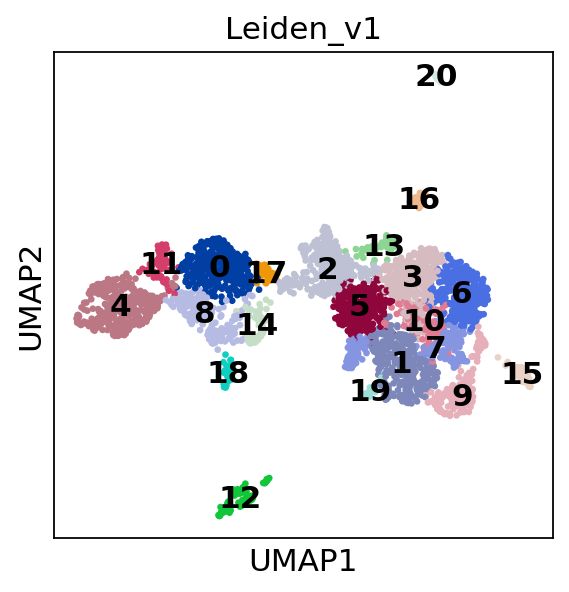

In [64]:
sc.pl.umap(adata, color='Leiden_v1', legend_loc='on data')

In [34]:
adata.write('./CD34_raw_afterQC_all_lognorm_hvg_processed_harmony.h5ad')

In [38]:
CT = pd.read_csv('Proj_results_velten.csv', index_col=0)

In [37]:
CT.head()

,Unnamed: 0,MinDist,MedianDist,MaxDist,SD,CT
0,AAAGCAATCTTGCAAG-Patient_3,15.621531,16.803038,17.482904,0.516168,GMP
1,AAAGTAGCACAACGTT-Patient_3,16.877186,18.219917,18.608778,0.446128,CMP
2,AACCATGCATCTCCCA-Patient_3,14.412119,16.091196,17.055296,0.806234,MEP
3,AACTCAGGTGGTCTCG-Patient_3,15.891893,18.137836,18.486671,0.702927,GMP
4,AACTCTTGTGAGGGAG-Patient_3,16.205177,17.592850,18.053778,0.490075,GMP


In [39]:
adata.obs_names

Index(['AAAGCAATCTTGCAAG-Patient_3', 'AAAGTAGCACAACGTT-Patient_3',
       'AACCATGCATCTCCCA-Patient_3', 'AACTCAGGTGGTCTCG-Patient_3',
       'AACTCTTGTGAGGGAG-Patient_3', 'AAGACCTTCCGGCACA-Patient_3',
       'ACATACGGTTACGGAG-Patient_3', 'ACCTTTAGTTTGTTTC-Patient_3',
       'ACTGAGTCAGCATGAG-Patient_3', 'AGAATAGTCTGTGCAA-Patient_3',
       ...
       'TGTCCCATCTGCGACG-Patient_7', 'TGTGTTTTCAACACAC-Patient_7',
       'TGTTCCGCAGGAATCG-Patient_7', 'TTAACTCAGGCACATG-Patient_7',
       'TTCTACAAGAACAATC-Patient_7', 'TTGAACGGTACACCGC-Patient_7',
       'TTGTAGGCAGACGTAG-Patient_7', 'TTGTAGGGTAATCGTC-Patient_7',
       'TTTGGTTAGCAATCTC-Patient_7', 'TTTGTCACAGTATGCT-Patient_7'],
      dtype='object', length=3312)

In [40]:
adata.obs['CT'] = CT['CT']

In [63]:
adata.write('./CD34_raw_afterQC_all_lognorm_hvg_processed_harmony.h5ad')

In [87]:
adata = sc.read('./CD34_raw_afterQC_all_lognorm_hvg_processed_harmony.h5ad')

In [88]:
adata = adata[~np.in1d(adata.obs['Leiden_v1'], ['12', '16', '20'])].copy()

In [89]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.external.pp.harmony_integrate(adata, key='plate')
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


2023-01-16 18:50:15,639 - harmonypy - INFO - Iteration 1 of 10
2023-01-16 18:50:16,081 - harmonypy - INFO - Iteration 2 of 10
2023-01-16 18:50:16,523 - harmonypy - INFO - Iteration 3 of 10
2023-01-16 18:50:16,927 - harmonypy - INFO - Iteration 4 of 10
2023-01-16 18:50:17,349 - harmonypy - INFO - Iteration 5 of 10
2023-01-16 18:50:17,717 - harmonypy - INFO - Iteration 6 of 10
2023-01-16 18:50:18,084 - harmonypy - INFO - Iteration 7 of 10
2023-01-16 18:50:18,360 - harmonypy - INFO - Iteration 8 of 10
2023-01-16 18:50:18,653 - harmonypy - INFO - Iteration 9 of 10
2023-01-16 18:50:19,003 - harmonypy - INFO - Iteration 10 of 10
2023-01-16 18:50:19,278 - harmonypy - INFO - Stopped before convergence


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


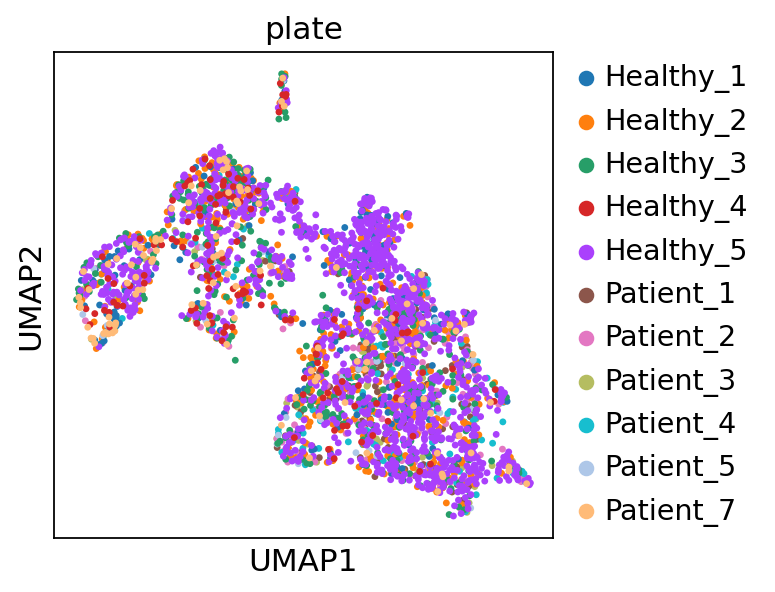

In [92]:
sc.pl.umap(adata, color='plate')

In [139]:
sc.tl.leiden(adata, resolution=1.5, key_added='Leiden_v2')

running Leiden clustering
    finished: found 22 clusters and added
    'Leiden_v2', the cluster labels (adata.obs, categorical) (0:00:00)


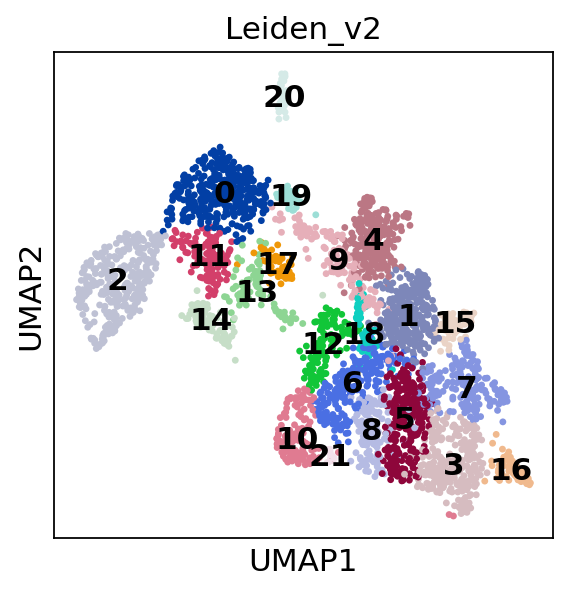

In [140]:
sc.pl.umap(adata, color='Leiden_v2', legend_loc='on data')

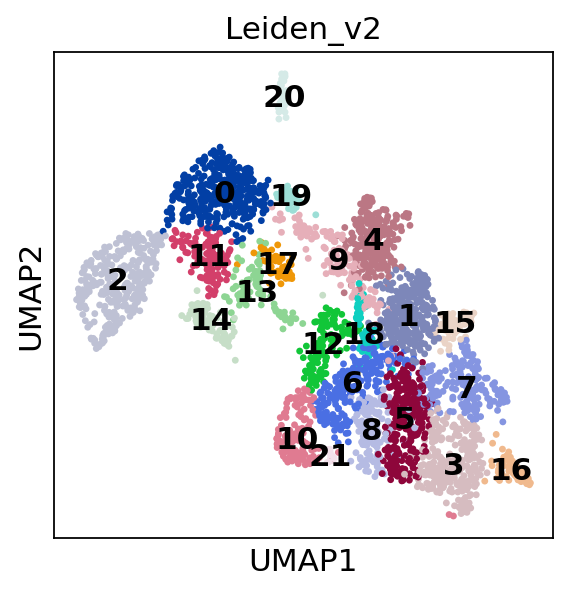

In [165]:
sc.pl.umap(adata, color='Leiden_v2', legend_loc='on data')

In [4]:
# Annotation from Velten et al. NCB 2017
GL = {
    'HSC': ['HLF', 'ZFP36L2'], 
    'CMP': ['HLF', 'ZFP36L2'],
    'Im-1': ['SELL', 'SPINK2', 'CD52'],
    'Im-2': ['TK1', 'TMEM92', 'SPINK2'],
    'sB-2': ['DNTT', 'VPREB1', 'HHIP'],
    'sB-1': ['JCHAIN', 'DNTT', 'CD79A'],
    'Mono': ['SCT', 'TGFBI', 'LGMN'],
    'N-0': ['MPO', 'RNASE2', 'ATP8B4'],
    'N-1': ['CTSG', 'AZU1', 'ELANE'],
    'N-2': ['AZU1', 'ELANE', 'PRTN3'],
    'N-3': ['LYZ', 'CSTA', 'LGALS1'],
    'MC': ['CLC', 'HDC', 'PRG2'],
    'ME-1': ['TK1', 'RRM2', 'ITGA2B'],
    'ME-2': ['CSF1', 'TFR2', 'CNRIP1'],
    'E-1': ['CA1', 'HBB', 'LMNA'],
    'E-2': ['HBB', 'AHSP', 'CA1'],
    'Mk': [ 'PLEK', 'ITGA2B']
}

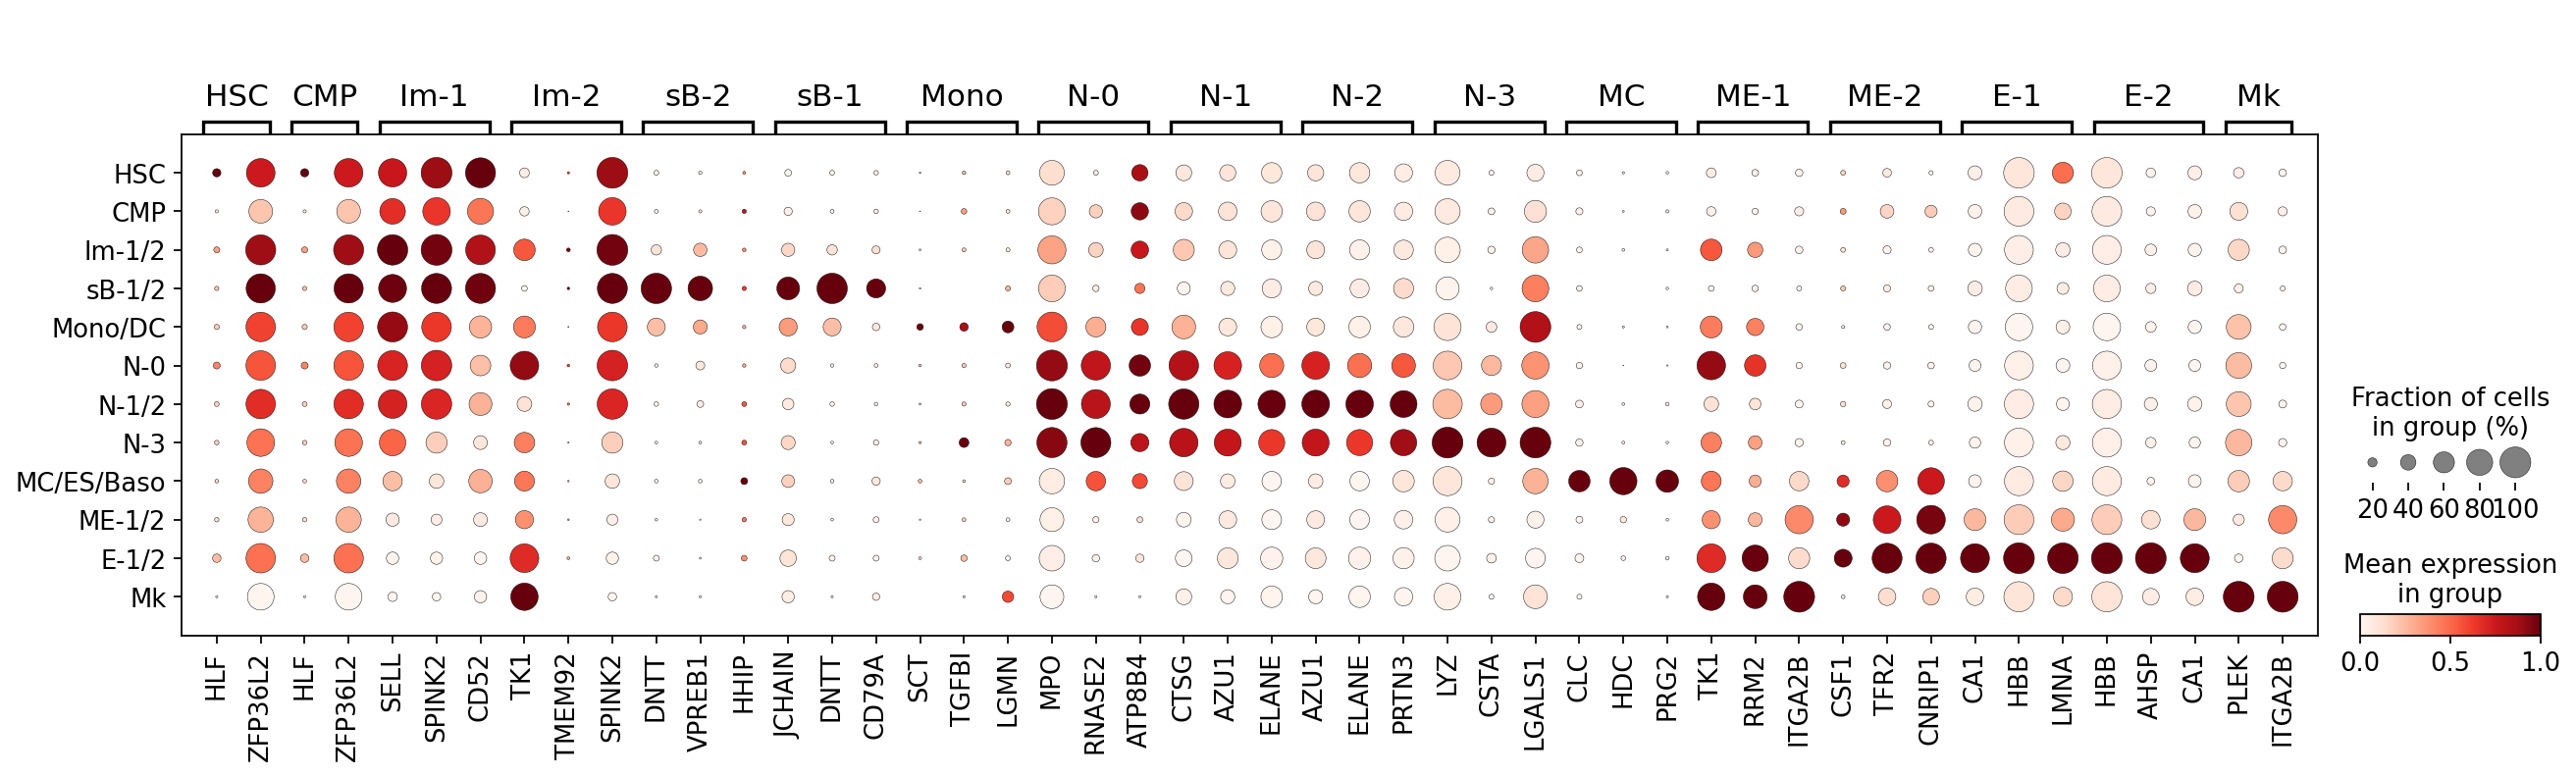

In [6]:
sc.pl.dotplot(adata, groupby='CT_new', var_names=GL, standard_scale='var')

In [7]:
CTassign = {
    '4': 'HSC',
    '9': 'CMP',
    '1': 'Im-1/2',
    '18': 'Im-1/2',
    '12': 'Im-1/2',
    '6': 'Im-1/2',
    '8': 'N-0',
    '5': 'N-1/2',
    '3': 'N-3',
    '16': 'N-3',
    '15': 'sB-1/2',
    '7': 'Mono/DC',
    '10': 'Im-1/2',
    '21': 'Im-1/2',
    '17': 'MC/ES/Baso',
    '2': 'E-1/2',
    '0': 'ME-1/2',
    '11': 'ME-1/2',
    '13': 'ME-1/2',
    '14': 'ME-1/2',
    '19': 'ME-1/2',
    '20': 'Mk'
}

In [172]:
adata.obs['CT_new'] = [CTassign[x] for x in adata.obs['Leiden_v2']]

In [10]:
adata.obs['CT_new'] = adata.obs['CT_new'].cat.reorder_categories(['HSC', 'CMP', 'Im-1/2', 'sB-1/2', 'Mono/DC', 'N-0', 'N-1/2', 'N-3','MC/ES/Baso', 'ME-1/2', 'E-1/2', 'Mk'])

In [12]:
adata.obs['CT_new'] = adata.obs['CT_new'].cat.rename_categories(['HSC', 'CMP', 'Myeloid(Im-1/2)', 'Pre-B cells(sB-1/2)', 'Mono/DC', 'Neut-0', 'Neut-1/2', 'Neut-3','Mast/Eosinophil/Basophil', 'Mega/Erythroid', 'Erythroid', 'Megakaryocyte'])

In [13]:
adata.obs['CT_new'].value_counts()

Myeloid(Im-1/2)             808
Mega/Erythroid              666
Neut-3                      330
Erythroid                   292
HSC                         260
Neut-1/2                    248
Mono/DC                     173
Neut-0                      132
CMP                         128
Pre-B cells(sB-1/2)          57
Mast/Eosinophil/Basophil     52
Megakaryocyte                34
Name: CT_new, dtype: int64

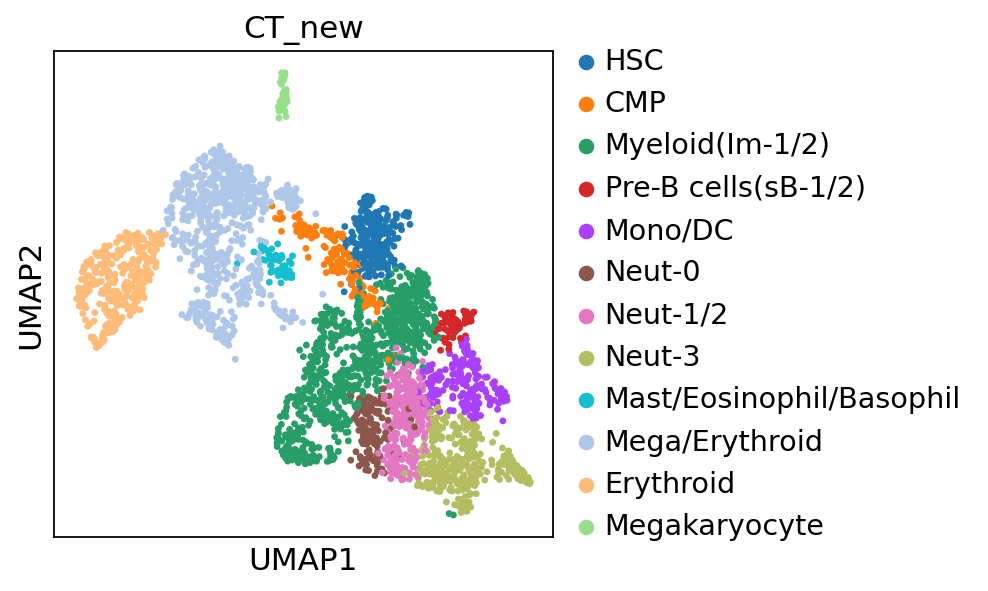

In [14]:
sc.pl.umap(adata, color='CT_new')

In [3]:
adata.obs['Condition'].value_counts()

Healthy    2535
Patient     645
Name: Condition, dtype: int64

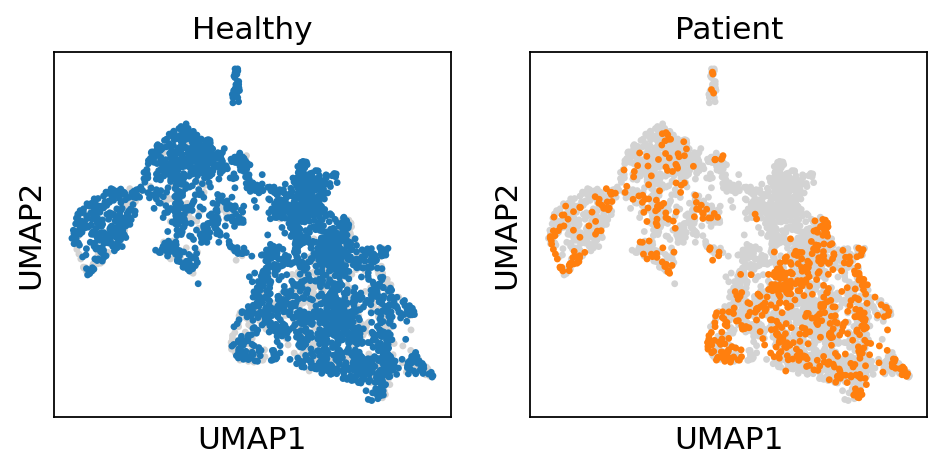

In [8]:
fig, ax = plt.subplots(1,2,figsize=(7,3))
sc.pl.umap(adata, color='Condition', groups=['Healthy'], legend_loc='', title='Healthy', ax=ax[0], show=False)
sc.pl.umap(adata, color='Condition', groups=['Patient'], legend_loc='', title='Patient', ax=ax[1], show=False)

Healthy
Patient


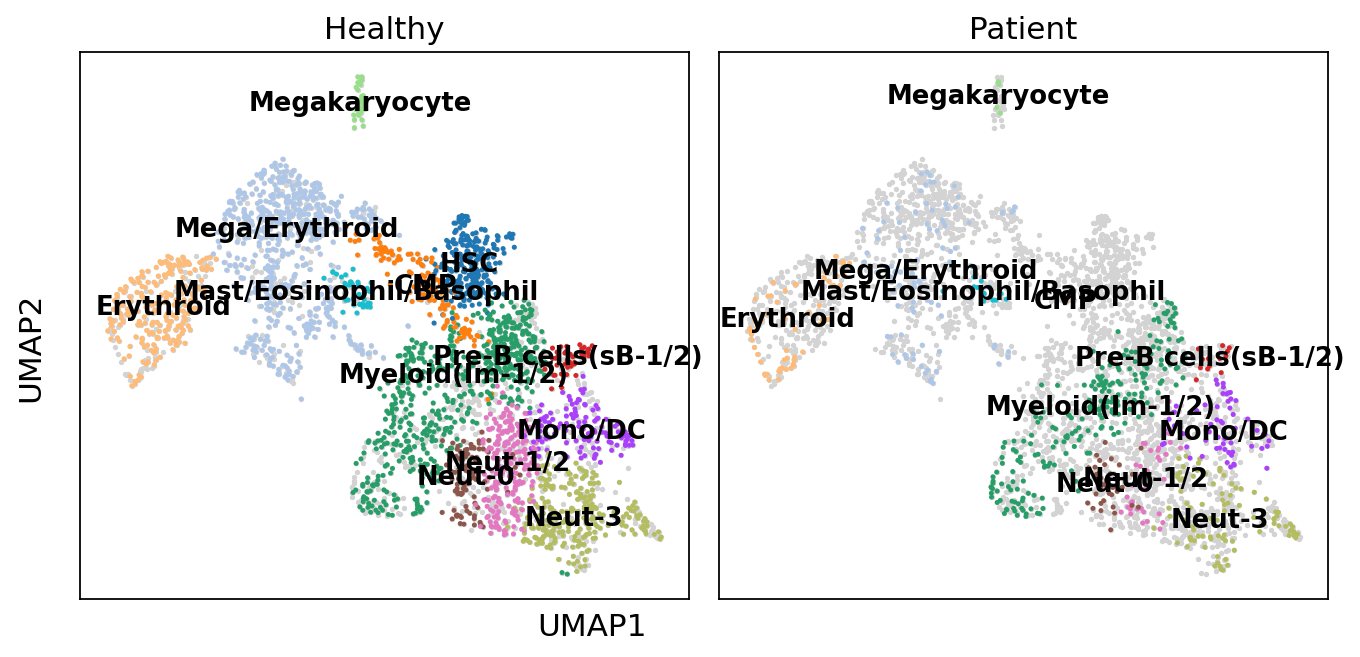

In [15]:
# Figure3E
# split in condition
fig, ax=plt.subplots(1,2, figsize=(10,4.5), squeeze=False)
ax = ax.flatten()
cat = adata.obs['Condition'].cat.categories
for i in range(len(cat)):
    print(cat[i])
    ax[i].scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1],s=2, c='#d3d3d3')
#     if i != 1:
#         legend_loc = ''
#     else:
#         legend_loc = 'right margin'
    sc.pl.umap(adata[adata.obs['Condition'] == cat[i]],s=20, color='CT_new', title=cat[i], ax=ax[i], show=False, legend_loc='on data', legend_fontsize='small')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    
fig.text(0.5, 0.1, 'UMAP1', ha='center')
fig.text(0.14, 0.5, 'UMAP2', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

In [16]:
adata.write('./write/CD34_raw_afterQC_all_lognorm_hvg_processed_harmony_filtered.h5ad')

In [3]:
adata = sc.read('./write/CD34_raw_afterQC_all_lognorm_hvg_processed_harmony_filtered.h5ad')

In [17]:
tab1 = pd.crosstab(adata.obs['CT_new'], adata.obs['Condition'], normalize=1).T*100

In [18]:
tab1

CT_new,HSC,CMP,Myeloid(Im-1/2),Pre-B cells(sB-1/2),Mono/DC,Neut-0,Neut-1/2,Neut-3,Mast/Eosinophil/Basophil,Mega/Erythroid,Erythroid,Megakaryocyte
Condition,,,,,,,,,,,,
Healthy,10.25641,4.930966,22.761341,1.735700,4.378698,3.786982,8.402367,9.428008,1.499014,22.603550,9.033531,1.183432
Patient,0.00000,0.465116,35.813953,2.015504,9.612403,5.581395,5.426357,14.108527,2.170543,14.418605,9.767442,0.620155


In [13]:
# c = {'Healthy': '#1CD9FF',
#     'Patient':'#FA1C26'
#     }

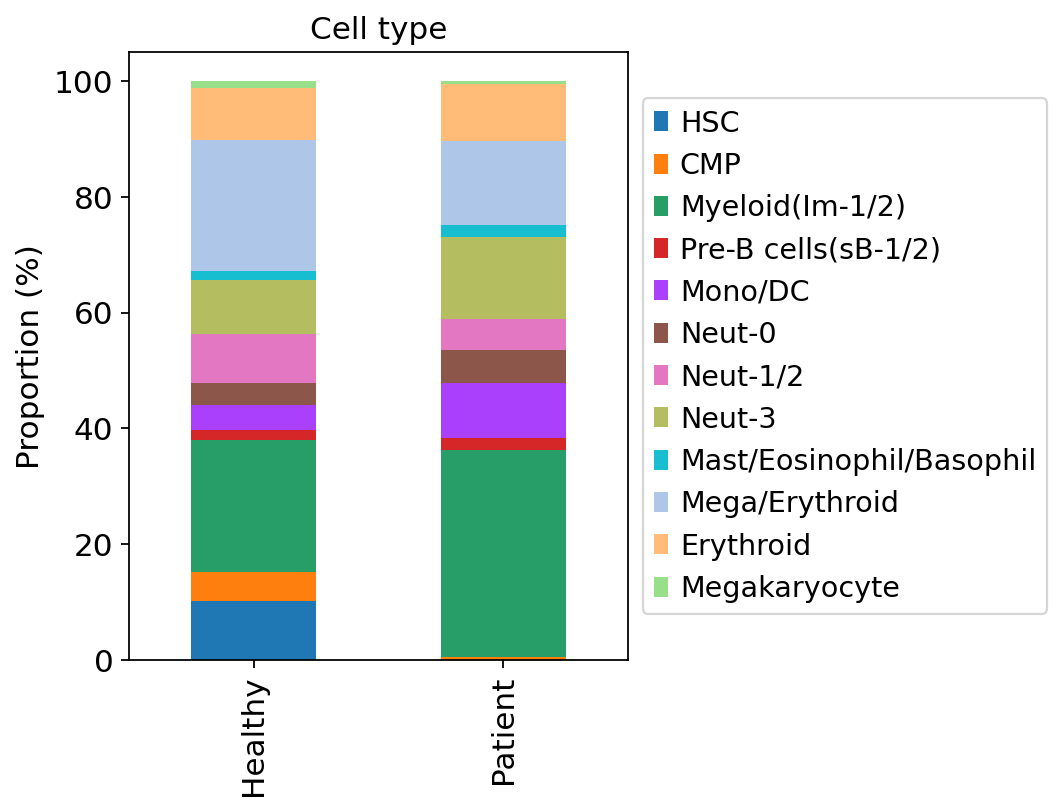

In [19]:
fig, ax = plt.subplots(figsize=(4,5))
tab1.iloc[[0,1],:].plot.bar(stacked=True, ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)
ax.set_ylabel('Proportion (%)')
ax.set_xlabel('')
ax.set_title('Cell type')
plt.savefig('Rod_CT_comparison.pdf', bbox_inches='tight')

In [20]:
tab1_v2 = pd.crosstab(adata.obs['CT_new'], adata.obs['Condition'])

In [21]:
tab1_v2

Condition,Healthy,Patient
CT_new,,
HSC,260,0
CMP,125,3
Myeloid(Im-1/2),577,231
Pre-B cells(sB-1/2),44,13
Mono/DC,111,62
Neut-0,96,36
Neut-1/2,213,35
Neut-3,239,91
Mast/Eosinophil/Basophil,38,14


In [15]:
tab1_v2.to_csv('table_CT_new.csv')